<a href="https://colab.research.google.com/github/rebeccahe1998/E4511-2021-HE/blob/main/Chembl_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 1.x

# get the Anaconda file 
! wget -c https://repo.anaconda.com/archive/Anaconda3-2019.10-Linux-x86_64.sh
! chmod +x Anaconda3-2019.10-Linux-x86_64.sh
! bash ./Anaconda3-2019.10-Linux-x86_64.sh -b -f -p /usr/local

! time conda install -y -c deepchem -c rdkit -c conda-forge -c omnia deepchem-gpu=2.3.0

import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')
import deepchem as dc

# install mordred, bravado and molvs
! time conda install -c conda-forge -y mordred bravado molvs

# get the Install AMPL_GPU_test.sh
!wget https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/config/install_AMPL_GPU_test.sh

# run the script to install AMPL
! chmod u+x install_AMPL_GPU_test.sh
! ./install_AMPL_GPU_test.sh

In [2]:
import warnings
warnings.filterwarnings('ignore')

import json
import os
import requests

# Import AMPL libraries
# 
import atomsci.ddm.utils.data_curation_functions as dcf
import atomsci.ddm.utils.curate_data as curate_data
import atomsci.ddm.pipeline.diversity_plots as dp
import atomsci.ddm.pipeline.chem_diversity as cd
# Additional python libraries
import pandas as pd
import numpy as np
import getpass,os

In [3]:
! wget https://raw.githubusercontent.com/rebeccahe1998/E4511-2021-HE/main/CHEMBL_SLC6A3_SMILES.csv

--2021-03-25 00:46:20--  https://raw.githubusercontent.com/rebeccahe1998/E4511-2021-HE/main/CHEMBL_SLC6A3_SMILES.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4164629 (4.0M) [text/plain]
Saving to: ‘CHEMBL_SLC6A3_SMILES.csv’

CHEMBL_SLC6A3_SMILE 100%[===================>]   3.97M  20.3MB/s    in 0.2s    

2021-03-25 00:46:23 (20.3 MB/s) - ‘CHEMBL_SLC6A3_SMILES.csv’ saved [4164629/4164629]



In [14]:
orig_df = pd.read_csv('CHEMBL_SLC6A3_SMILES.csv', header = 0)
orig_df=orig_df.drop(columns=orig_df.iloc[:,0:2])
orig_df

,Molecule_ChEMBL_ID,Molecule_Name,Molecule_Max_Phase,Molecular_Weight,#RO5_Violations,AlogP,Compound_Key,Smiles,Standard_Type,Standard_Relation,Standard_Value,Standard_Units,pChEMBL_Value,Data_Validity_Comment,Comment,Uo_Units,Ligand_Efficiency_BEI,Ligand_Efficiency_LE,Ligand_Efficiency_LLE,Ligand_Efficiency_SEI,Potential_Duplicate,Assay_ChEMBL_ID,Assay_Description,Assay_Type,BAO_Format_ID,BAO_Label,Assay_Organism,Assay_Tissue_ChEMBL_ID,Assay_Tissue_Name,Assay_Cell_Type,Assay_Subcellular_Fraction,Assay_Parameters,Assay_Variant_Accession,Assay_Variant_Mutation,Target_ChEMBL_ID,Target_Name,Target_Organism,Target_Type,Document_ChEMBL_ID,Source_ID,Source_Description,Document_Journal,Document_Year,Cell_ChEMBL_ID,Properties,Standard_Value_nM,base_rdkit_smiles
0,CHEMBL4095847,NaN,0.0,397.53,0.0,4.45,1q,c1ccc(CC2CCN(CCn3nnnc3-c3cccc4ccccc34)CC2)cc1,IC50,'>',10000.00,nM,NaN,NaN,NaN,UO_0000065,NaN,NaN,NaN,NaN,False,CHEMBL4046313,Inhibition of re-uptake of [3H]-DA at human DA...,B,BAO_0000219,cell-based format,Homo sapiens,NaN,NaN,HEK293,NaN,NaN,NaN,NaN,CHEMBL238,Dopamine transporter,Homo sapiens,SINGLE PROTEIN,CHEMBL4043179,1,Scientific Literature,Bioorg Med Chem,2017.0,CHEMBL3307715,NaN,10000.00,c1ccc(CC2CCN(CCn3nnnc3-c3cccc4ccccc34)CC2)cc1
1,CHEMBL4099475,NaN,0.0,403.53,0.0,3.89,2c,CC(=O)c1cccc(-c2nnnn2CCCN2CCC(Cc3ccccc3)CC2)c1,IC50,'=',5040.00,nM,5.30,NaN,NaN,UO_0000065,13.13,0.24,1.41,8.29,False,CHEMBL4046313,Inhibition of re-uptake of [3H]-DA at human DA...,B,BAO_0000219,cell-based format,Homo sapiens,NaN,NaN,HEK293,NaN,NaN,NaN,NaN,CHEMBL238,Dopamine transporter,Homo sapiens,SINGLE PROTEIN,CHEMBL4043179,1,Scientific Literature,Bioorg Med Chem,2017.0,CHEMBL3307715,NaN,5040.00,CC(=O)c1cccc(-c2nnnn2CCCN2CCC(Cc3ccccc3)CC2)c1
2,CHEMBL4072303,NaN,0.0,487.97,0.0,2.22,15,CNc1nc(C#Cc2ccc(Cl)s2)nc2c1ncn2[C@H]1[C@H](O)[...,Inhibition,'=',36.00,%,NaN,NaN,NaN,UO_0000187,NaN,NaN,NaN,NaN,False,CHEMBL4011334,"Inhibition of [3H]WIN35,428 binding to recombi...",B,BAO_0000219,cell-based format,Homo sapiens,NaN,NaN,HEK293,NaN,NaN,NaN,NaN,CHEMBL238,Dopamine transporter,Homo sapiens,SINGLE PROTEIN,CHEMBL4007505,1,Scientific Literature,J Med Chem,2017.0,CHEMBL3307715,NaN,36.00,CNc1nc(C#Cc2ccc(Cl)s2)nc2c1ncn2[C@H]1[C@H](O)[...
3,CHEMBL272074,NaN,0.0,326.44,0.0,3.20,rac-6i,CCN(CC)C(=O)C1(c2ccccc2)CC1CNCc1ccco1,IC50,'>',10000.00,nM,NaN,NaN,NaN,UO_0000065,NaN,NaN,NaN,NaN,False,CHEMBL932890,Inhibition of human DAT,B,BAO_0000357,single protein format,Homo sapiens,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHEMBL238,Dopamine transporter,Homo sapiens,SINGLE PROTEIN,CHEMBL1143218,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2008.0,NaN,NaN,10000.00,CCN(CC)C(=O)C1(c2ccccc2)CC1CNCc1ccco1
4,CHEMBL270607,NaN,0.0,399.92,0.0,3.77,9n,CNCc1cc(C(=O)N2CCN(C3CC3)CC2)ccc1Oc1cccc(Cl)c1,Ki,'=',7000.00,nM,5.16,NaN,NaN,UO_0000065,12.89,0.25,1.38,11.50,False,CHEMBL948194,Binding affinity to human DAT,B,BAO_0000357,single protein format,Homo sapiens,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHEMBL238,Dopamine transporter,Homo sapiens,SINGLE PROTEIN,CHEMBL1141555,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2008.0,NaN,NaN,7000.00,CNCc1cc(C(=O)N2CCN(C3CC3)CC2)ccc1Oc1cccc(Cl)c1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7926,CHEMBL4077643,NaN,0.0,338.43,0.0,3.53,7d,Cc1nc(O)cc(C[S+]([O-])C(c2ccccc2)c2ccccc2)n1,Activity,NaN,NaN,NaN,NaN,NaN,Non-Toxic,NaN,NaN,NaN,NaN,NaN,False,CHEMBL4032124,Substrate activity at human DAT expressed in H...,A,BAO_0000219,cell-based format,Homo sapiens,NaN,NaN,HEK293,NaN,NaN,NaN,NaN,CHEMBL238,Dopamine transporter,Homo sapiens,SINGLE PROTEIN,CHEMBL4028886,1,Scientific Literature,J Med Chem,2017.0,CHEMBL3307715,NaN,NaN,Cc1nc(O)cc(C[S+]([O-])C(c2ccccc2)c2ccccc2)n1
7927,CHEMBL4448899,NaN,0.0,496.42,0.0,4.17,NaN,Cc1c(NC(=O)c2cc(C(N)=O)nc3cc(F)ccc23)c(C(F)(F)...,Inhibition,'=',8.22,%,NaN,NaN,Not Active,UO_0000187,NaN,NaN,NaN,NaN,False,CH

In [15]:
orig_df.columns = orig_df.columns.str.lower()

In [16]:
orig_df

,molecule_chembl_id,molecule_name,molecule_max_phase,molecular_weight,#ro5_violations,alogp,compound_key,smiles,standard_type,standard_relation,standard_value,standard_units,pchembl_value,data_validity_comment,comment,uo_units,ligand_efficiency_bei,ligand_efficiency_le,ligand_efficiency_lle,ligand_efficiency_sei,potential_duplicate,assay_chembl_id,assay_description,assay_type,bao_format_id,bao_label,assay_organism,assay_tissue_chembl_id,assay_tissue_name,assay_cell_type,assay_subcellular_fraction,assay_parameters,assay_variant_accession,assay_variant_mutation,target_chembl_id,target_name,target_organism,target_type,document_chembl_id,source_id,source_description,document_journal,document_year,cell_chembl_id,properties,standard_value_nm,base_rdkit_smiles
0,CHEMBL4095847,NaN,0.0,397.53,0.0,4.45,1q,c1ccc(CC2CCN(CCn3nnnc3-c3cccc4ccccc34)CC2)cc1,IC50,'>',10000.00,nM,NaN,NaN,NaN,UO_0000065,NaN,NaN,NaN,NaN,False,CHEMBL4046313,Inhibition of re-uptake of [3H]-DA at human DA...,B,BAO_0000219,cell-based format,Homo sapiens,NaN,NaN,HEK293,NaN,NaN,NaN,NaN,CHEMBL238,Dopamine transporter,Homo sapiens,SINGLE PROTEIN,CHEMBL4043179,1,Scientific Literature,Bioorg Med Chem,2017.0,CHEMBL3307715,NaN,10000.00,c1ccc(CC2CCN(CCn3nnnc3-c3cccc4ccccc34)CC2)cc1
1,CHEMBL4099475,NaN,0.0,403.53,0.0,3.89,2c,CC(=O)c1cccc(-c2nnnn2CCCN2CCC(Cc3ccccc3)CC2)c1,IC50,'=',5040.00,nM,5.30,NaN,NaN,UO_0000065,13.13,0.24,1.41,8.29,False,CHEMBL4046313,Inhibition of re-uptake of [3H]-DA at human DA...,B,BAO_0000219,cell-based format,Homo sapiens,NaN,NaN,HEK293,NaN,NaN,NaN,NaN,CHEMBL238,Dopamine transporter,Homo sapiens,SINGLE PROTEIN,CHEMBL4043179,1,Scientific Literature,Bioorg Med Chem,2017.0,CHEMBL3307715,NaN,5040.00,CC(=O)c1cccc(-c2nnnn2CCCN2CCC(Cc3ccccc3)CC2)c1
2,CHEMBL4072303,NaN,0.0,487.97,0.0,2.22,15,CNc1nc(C#Cc2ccc(Cl)s2)nc2c1ncn2[C@H]1[C@H](O)[...,Inhibition,'=',36.00,%,NaN,NaN,NaN,UO_0000187,NaN,NaN,NaN,NaN,False,CHEMBL4011334,"Inhibition of [3H]WIN35,428 binding to recombi...",B,BAO_0000219,cell-based format,Homo sapiens,NaN,NaN,HEK293,NaN,NaN,NaN,NaN,CHEMBL238,Dopamine transporter,Homo sapiens,SINGLE PROTEIN,CHEMBL4007505,1,Scientific Literature,J Med Chem,2017.0,CHEMBL3307715,NaN,36.00,CNc1nc(C#Cc2ccc(Cl)s2)nc2c1ncn2[C@H]1[C@H](O)[...
3,CHEMBL272074,NaN,0.0,326.44,0.0,3.20,rac-6i,CCN(CC)C(=O)C1(c2ccccc2)CC1CNCc1ccco1,IC50,'>',10000.00,nM,NaN,NaN,NaN,UO_0000065,NaN,NaN,NaN,NaN,False,CHEMBL932890,Inhibition of human DAT,B,BAO_0000357,single protein format,Homo sapiens,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHEMBL238,Dopamine transporter,Homo sapiens,SINGLE PROTEIN,CHEMBL1143218,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2008.0,NaN,NaN,10000.00,CCN(CC)C(=O)C1(c2ccccc2)CC1CNCc1ccco1
4,CHEMBL270607,NaN,0.0,399.92,0.0,3.77,9n,CNCc1cc(C(=O)N2CCN(C3CC3)CC2)ccc1Oc1cccc(Cl)c1,Ki,'=',7000.00,nM,5.16,NaN,NaN,UO_0000065,12.89,0.25,1.38,11.50,False,CHEMBL948194,Binding affinity to human DAT,B,BAO_0000357,single protein format,Homo sapiens,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHEMBL238,Dopamine transporter,Homo sapiens,SINGLE PROTEIN,CHEMBL1141555,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2008.0,NaN,NaN,7000.00,CNCc1cc(C(=O)N2CCN(C3CC3)CC2)ccc1Oc1cccc(Cl)c1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7926,CHEMBL4077643,NaN,0.0,338.43,0.0,3.53,7d,Cc1nc(O)cc(C[S+]([O-])C(c2ccccc2)c2ccccc2)n1,Activity,NaN,NaN,NaN,NaN,NaN,Non-Toxic,NaN,NaN,NaN,NaN,NaN,False,CHEMBL4032124,Substrate activity at human DAT expressed in H...,A,BAO_0000219,cell-based format,Homo sapiens,NaN,NaN,HEK293,NaN,NaN,NaN,NaN,CHEMBL238,Dopamine transporter,Homo sapiens,SINGLE PROTEIN,CHEMBL4028886,1,Scientific Literature,J Med Chem,2017.0,CHEMBL3307715,NaN,NaN,Cc1nc(O)cc(C[S+]([O-])C(c2ccccc2)c2ccccc2)n1
7927,CHEMBL4448899,NaN,0.0,496.42,0.0,4.17,NaN,Cc1c(NC(=O)c2cc(C(N)=O)nc3cc(F)ccc23)c(C(F)(F)...,Inhibition,'=',8.22,%,NaN,NaN,Not Active,UO_0000187,NaN,NaN,NaN,NaN,False,CH

In [18]:
orig_df.columns

Index(['molecule_chembl_id', 'molecule_name', 'molecule_max_phase',
       'molecular_weight', '#ro5_violations', 'alogp', 'compound_key',
       'smiles', 'standard_type', 'standard_relation', 'standard_value',
       'standard_units', 'pchembl_value', 'data_validity_comment', 'comment',
       'uo_units', 'ligand_efficiency_bei', 'ligand_efficiency_le',
       'ligand_efficiency_lle', 'ligand_efficiency_sei', 'potential_duplicate',
       'assay_chembl_id', 'assay_description', 'assay_type', 'bao_format_id',
       'bao_label', 'assay_organism', 'assay_tissue_chembl_id',
       'assay_tissue_name', 'assay_cell_type', 'assay_subcellular_fraction',
       'assay_parameters', 'assay_variant_accession', 'assay_variant_mutation',
       'target_chembl_id', 'target_name', 'target_organism', 'target_type',
       'document_chembl_id', 'source_id', 'source_description',
       'document_journal', 'document_year', 'cell_chembl_id', 'properties',
       'standard_value_nm', 'base_rdkit_smiles'

In [20]:
df = orig_df[['molecule_chembl_id','smiles', 'standard_type', 'standard_relation', 'standard_value','standard_units', 'pchembl_value','base_rdkit_smiles']]
df

,molecule_chembl_id,smiles,standard_type,standard_relation,standard_value,standard_units,pchembl_value,base_rdkit_smiles
0,CHEMBL4095847,c1ccc(CC2CCN(CCn3nnnc3-c3cccc4ccccc34)CC2)cc1,IC50,'>',10000.00,nM,NaN,c1ccc(CC2CCN(CCn3nnnc3-c3cccc4ccccc34)CC2)cc1
1,CHEMBL4099475,CC(=O)c1cccc(-c2nnnn2CCCN2CCC(Cc3ccccc3)CC2)c1,IC50,'=',5040.00,nM,5.30,CC(=O)c1cccc(-c2nnnn2CCCN2CCC(Cc3ccccc3)CC2)c1
2,CHEMBL4072303,CNc1nc(C#Cc2ccc(Cl)s2)nc2c1ncn2[C@H]1[C@H](O)[...,Inhibition,'=',36.00,%,NaN,CNc1nc(C#Cc2ccc(Cl)s2)nc2c1ncn2[C@H]1[C@H](O)[...
3,CHEMBL272074,CCN(CC)C(=O)C1(c2ccccc2)CC1CNCc1ccco1,IC50,'>',10000.00,nM,NaN,CCN(CC)C(=O)C1(c2ccccc2)CC1CNCc1ccco1
4,CHEMBL270607,CNCc1cc(C(=O)N2CCN(C3CC3)CC2)ccc1Oc1cccc(Cl)c1,Ki,'=',7000.00,nM,5.16,CNCc1cc(C(=O)N2CCN(C3CC3)CC2)ccc1Oc1cccc(Cl)c1
...,...,...,...,...,...,...,...,...
7926,CHEMBL4077643,Cc1nc(O)cc(C[S+]([O-])C(c2ccccc2)c2ccccc2)n1,Activity,NaN,NaN,NaN,NaN,Cc1nc(O)cc(C[S+]([O-])C(c2ccccc2)c2ccccc2)n1
7927,CHEMBL4448899,Cc1c(NC(=O)c2cc(C(N)=O)nc3cc(F)ccc23)c(C(F)(F)...,Inhibition,'=',8.22,%,NaN,Cc1c(NC(=O)c2cc(C(N)=O)nc3cc(F)ccc23)c(C(F)(F)...
7928,CHEMBL4564992,CN(CCOc1cc(COc2ccccc2)on1)C1CCCCC1.Cl,Ki,'>',10000.00,nM,NaN,CN(CCOc1cc(COc2ccccc2)on1)C1CCCCC1
7929,CHEMBL3673172,Fc1ccc(C23CCN(CC2)Cc2cc(Oc4ccc(C(F)(F)F)nn4)cc...,IC50,'=',63.20,nM,7.20,Fc1ccc(C23CCN(CC2)Cc2cc(Oc4ccc(C(F)(F)F)nn4)cc...


In [21]:
df.standard_type.value_counts()

IC50                                                   3309
Ki                                                     2990
Inhibition                                             1156
Activity                                                180
Ratio                                                    76
pKD                                                      56
Log 1/C                                                  50
EC50                                                     47
Kd                                                       21
% Inhibition of Control Specific Binding (Mean n=2)       8
% Ctrl                                                    8
Displacement                                              6
IC5                                                       4
Ratio Ki                                                  4
pKi                                                       3
Ratio IC50                                                2
Efficacy                                

In [26]:
print(sum(df['pchembl_value'].isna()) )
print(len(df) - sum(df['pchembl_value'].isna()))

len(orig_df)


4096
3835


7931

In [ ]:
# filter out to have df of standard type IC/EC50, non empty standard value, non empoty inchi key,
# non-empty compound id, standard units = 'NM'

In [28]:
df.columns

Index(['molecule_chembl_id', 'smiles', 'standard_type', 'standard_relation',
       'standard_value', 'standard_units', 'pchembl_value',
       'base_rdkit_smiles'],
      dtype='object')

In [31]:
dset_df = df[~(df.molecule_chembl_id.isna())  &
            (df.standard_units == 'nM') &
            ~df.standard_value.isna() &
             (df.standard_relation == "'='" ) &
             ~df.standard_relation.isna()&
             ~df.pchembl_value.isna()]

In [32]:
dset_df = dset_df.loc[(df.standard_type == 'IC50') | (df.standard_type == 'EC50')]
dset_df

,molecule_chembl_id,smiles,standard_type,standard_relation,standard_value,standard_units,pchembl_value,base_rdkit_smiles
1,CHEMBL4099475,CC(=O)c1cccc(-c2nnnn2CCCN2CCC(Cc3ccccc3)CC2)c1,IC50,'=',5040.0,nM,5.30,CC(=O)c1cccc(-c2nnnn2CCCN2CCC(Cc3ccccc3)CC2)c1
6,CHEMBL3317704,C[C@@H]1NCCCN(c2ccc3ccccc3c2)C1=O.Cl,IC50,'=',160.0,nM,6.80,C[C@@H]1NCCCN(c2ccc3ccccc3c2)C1=O
12,CHEMBL203403,CCCC(C(=O)c1ccccc1C)N1CCCC1,IC50,'=',63.0,nM,7.20,CCCC(C(=O)c1ccccc1C)N1CCCC1
14,CHEMBL204288,CCCC(C(=O)c1ccc(Cl)c(Cl)c1)N1CCCCC1,IC50,'=',666.0,nM,6.18,CCCC(C(=O)c1ccc(Cl)c(Cl)c1)N1CCCCC1
17,CHEMBL370158,C[N+]1(CCl)C2C=C(c3ccccc3-c3ccccc3)CC1CC2,IC50,'=',67000.0,nM,4.17,C[N+]1(CCl)C2C=C(c3ccccc3-c3ccccc3)CC1CC2
...,...,...,...,...,...,...,...,...
7911,CHEMBL3944260,O=C(OC(c1ccccc1)C1CNC1)c1ccccc1,IC50,'=',1683.0,nM,5.77,O=C(OC(c1ccccc1)C1CNC1)c1ccccc1
7913,CHEMBL3703746,Clc1ccc(C2CNCc3cc(-c4ccc5ncnn5c4)ccc32)cc1Cl,IC50,'=',30.8,nM,7.51,Clc1ccc(C2CNCc3cc(-c4ccc5ncnn5c4)ccc32)cc1Cl
7919,CHEMBL3407785,CNC(=O)[C@@]12C[C@@H]1[C@@H](n1cnc3c(NC)nc(C#C...,EC50,'=',870.0,nM,6.06,CNC(=O)[C@@]12C[C@@H]1[C@@H](n1cnc3c(NC)nc(C#C...
7922,CHEMBL4092411,CNc1nc(C#Cc2ccc(Cl)s2)nc2c1ncn2[C@@H]1O[C@H](C...,IC50,'=',396.0,nM,6.40,CNc1nc(C#Cc2ccc(Cl)s2)nc2c1ncn2[C@@H]1O[C@H](C...


In [36]:
sum(df.base_rdkit_smiles.isna())

0

In [ ]:
for col in dset_df.columns:
    print(dset_df[col].value_counts())

In [37]:
dset_df.dtypes

molecule_chembl_id     object
smiles                 object
standard_type          object
standard_relation      object
standard_value        float64
standard_units         object
pchembl_value         float64
base_rdkit_smiles      object
dtype: object

In [38]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [42]:
dset_df.to_csv('drive/MyDrive/CHEMBL_DROP.csv')

Canonicalizing 1631 molecules...
Done
Computing fingerprints...
Done
Computing Tanimoto distance matrix...
Done


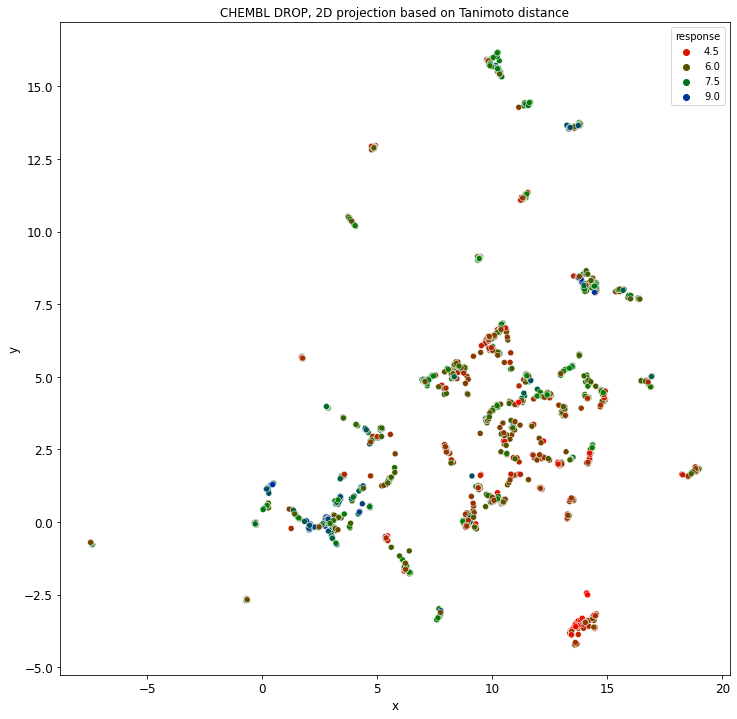

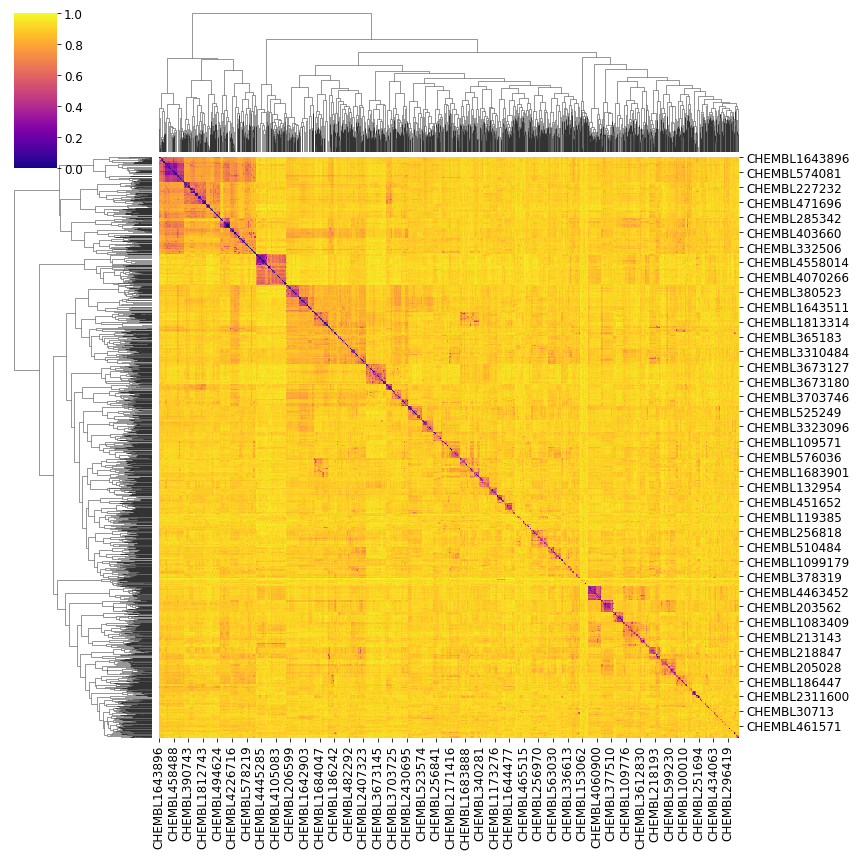

In [45]:

dp.diversity_plots(dset_key = 'drive/MyDrive/CHEMBL_DROP.csv',
                   datastore = False,
                   response_col = 'pchembl_value', smiles_col='base_rdkit_smiles',id_col='molecule_chembl_id',
                   max_for_mcs = 100)

In [46]:
feat_type = 'ECFP'
dist_metric = 'tanimoto'
smiles_lst1 = dset_df['base_rdkit_smiles'].tolist()
calc_type = 'nearest'
dist_sample = cd.calc_dist_smiles(feat_type, dist_metric, smiles_lst1, None, calc_type)

print(len(dist_sample))
print(len(smiles_lst1))

2033
2033


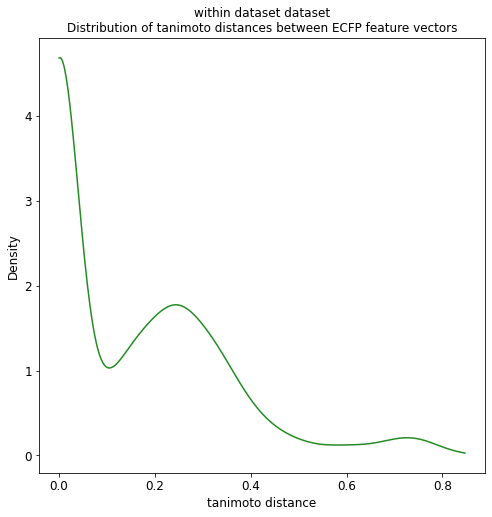

In [47]:
from scipy.stats.kde import gaussian_kde

# import math library
import numpy as np

# for creating plots
import matplotlib.pyplot as plt

# current directory
odir='./'

# name for the task
task_name='within dataset'

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html
dist_pdf = gaussian_kde(dist_sample)
x_plt = np.linspace(min(dist_sample), max(dist_sample), 500)
y_plt = dist_pdf(x_plt)    
fig, ax = plt.subplots(figsize=(8.0,8.0))
ax.plot(x_plt, y_plt, color='forestgreen')
ax.set_xlabel('%s distance' % dist_metric)
ax.set_ylabel('Density')
ax.set_title("%s dataset\nDistribution of %s distances between %s feature vectors" % (
              task_name, dist_metric, feat_type))
fig.savefig(odir+'distance_to_background_mol.png')

In [48]:
dset_df

,molecule_chembl_id,smiles,standard_type,standard_relation,standard_value,standard_units,pchembl_value,base_rdkit_smiles
1,CHEMBL4099475,CC(=O)c1cccc(-c2nnnn2CCCN2CCC(Cc3ccccc3)CC2)c1,IC50,'=',5040.0,nM,5.30,CC(=O)c1cccc(-c2nnnn2CCCN2CCC(Cc3ccccc3)CC2)c1
6,CHEMBL3317704,C[C@@H]1NCCCN(c2ccc3ccccc3c2)C1=O.Cl,IC50,'=',160.0,nM,6.80,C[C@@H]1NCCCN(c2ccc3ccccc3c2)C1=O
12,CHEMBL203403,CCCC(C(=O)c1ccccc1C)N1CCCC1,IC50,'=',63.0,nM,7.20,CCCC(C(=O)c1ccccc1C)N1CCCC1
14,CHEMBL204288,CCCC(C(=O)c1ccc(Cl)c(Cl)c1)N1CCCCC1,IC50,'=',666.0,nM,6.18,CCCC(C(=O)c1ccc(Cl)c(Cl)c1)N1CCCCC1
17,CHEMBL370158,C[N+]1(CCl)C2C=C(c3ccccc3-c3ccccc3)CC1CC2,IC50,'=',67000.0,nM,4.17,C[N+]1(CCl)C2C=C(c3ccccc3-c3ccccc3)CC1CC2
...,...,...,...,...,...,...,...,...
7911,CHEMBL3944260,O=C(OC(c1ccccc1)C1CNC1)c1ccccc1,IC50,'=',1683.0,nM,5.77,O=C(OC(c1ccccc1)C1CNC1)c1ccccc1
7913,CHEMBL3703746,Clc1ccc(C2CNCc3cc(-c4ccc5ncnn5c4)ccc32)cc1Cl,IC50,'=',30.8,nM,7.51,Clc1ccc(C2CNCc3cc(-c4ccc5ncnn5c4)ccc32)cc1Cl
7919,CHEMBL3407785,CNC(=O)[C@@]12C[C@@H]1[C@@H](n1cnc3c(NC)nc(C#C...,EC50,'=',870.0,nM,6.06,CNC(=O)[C@@]12C[C@@H]1[C@@H](n1cnc3c(NC)nc(C#C...
7922,CHEMBL4092411,CNc1nc(C#Cc2ccc(Cl)s2)nc2c1ncn2[C@@H]1O[C@H](C...,IC50,'=',396.0,nM,6.40,CNc1nc(C#Cc2ccc(Cl)s2)nc2c1ncn2[C@@H]1O[C@H](C...


In [50]:

import os

# From our dataframe, we are working with the PIC50 column 
data=dset_df

column = 'pchembl_value'

# tolerance: Percentage of individual respsonse values allowed to different from 
# the average to be included in averaging
tolerance = 10

# list_bad_duplicates: Print structures with bad duplicates
list_bad_duplicates = 'Yes'

# max_std: Maximum allowed standard deviation for computed average response value
# NOTE: In this example, we set this value very high to disable this feature
max_std = 1

# compound_id: Compound ID column
compound_id = 'molecule_chembl_id'

# smiles_col: SMILES column
smiles_col = 'base_rdkit_smiles'

# Here we are creating a new dataframe, called check_df
check_df = curate_data.average_and_remove_duplicates(column, tolerance, 
                                                       list_bad_duplicates, 
                                                       data, max_std, 
                                                       compound_id=compound_id, 
                                                       smiles_col=smiles_col)

Bad duplicates removed from dataset
Dataframe size (2001, 12)
List of 'bad' duplicates removed
     molecule_chembl_id  pchembl_value  ...   Perc_Var  VALUE_NUM_std
733       CHEMBL1173276           5.48  ...  14.641745       1.329361
684       CHEMBL1173276           7.36  ...  14.641745       1.329361
458        CHEMBL180672           9.70  ...  18.292683       2.121320
1675      CHEMBL2112075           6.70  ...  18.292683       2.121320
557        CHEMBL218847           8.13  ...  12.292818       1.258650
763        CHEMBL218847           6.35  ...  12.292818       1.258650
1216       CHEMBL218848           6.00  ...  11.111111       1.060660
507        CHEMBL218848           7.50  ...  11.111111       1.060660
1031       CHEMBL219116           5.57  ...  17.664449       1.689985
833        CHEMBL219116           7.96  ...  17.664449       1.689985
400        CHEMBL219224           7.66  ...  13.649852       1.301076
1577       CHEMBL219224           5.82  ...  13.649852       1.30

In [51]:

old_compound_id='base_rdkit_smiles'
new_compound_id='base_rdkit_smiles'

# Takes all the compounds that aren't part of the curated data frame and prints them
reject=data[~data[old_compound_id].isin(check_df[new_compound_id])]
reject

,molecule_chembl_id,smiles,standard_type,standard_relation,standard_value,standard_units,pchembl_value,base_rdkit_smiles
564,CHEMBL486278,COc1ccc(CC(C)(C)NC[C@H](O)COc2cccc3[nH]c(=O)[n...,IC50,'=',1200.0,nM,5.92,COc1ccc(CC(C)(C)NC[C@H](O)COc2cccc3[nH]c(=O)[n...
603,CHEMBL310650,COC(=O)[C@@H]1C2CCC(C[C@@H]1OC(c1ccc(F)cc1)c1c...,IC50,'=',10.9,nM,7.96,COC(=O)[C@@H]1C2CCC(C[C@@H]1OC(c1ccc(F)cc1)c1c...
792,CHEMBL220195,COC(=O)C(c1ccc(Cl)c(Cl)c1)C1CCCCN1,IC50,'=',23.0,nM,7.64,COC(=O)C(c1ccc(Cl)c(Cl)c1)C1CCCCN1
1580,CHEMBL219335,CC(C)CC(c1cccc(Cl)c1)C1CCCCN1,IC50,'=',88.0,nM,7.06,CC(C)CC(c1cccc(Cl)c1)C1CCCCN1
1581,CHEMBL219224,CC(c1ccc(Cl)cc1)C1CCCCN1,IC50,'=',22.0,nM,7.66,CC(c1ccc(Cl)cc1)C1CCCCN1
1729,CHEMBL180672,CC(C)(Cc1ccc2ccccc2c1)NC[C@@H](O)COc1cccc(Cl)c...,IC50,'=',0.2,nM,9.70,CC(C)(Cc1ccc2ccccc2c1)NC[C@@H](O)COc1cccc(Cl)c...
1959,CHEMBL218848,CC(C)C(c1ccc(Cl)cc1)C1CCCCN1,IC50,'=',32.0,nM,7.50,CC(C)C(c1ccc(Cl)cc1)C1CCCCN1
1983,CHEMBL310650,COC(=O)[C@@H]1C2CCC(C[C@@H]1OC(c1ccc(F)cc1)c1c...,IC50,'=',10.9,nM,7.96,COC(=O)[C@@H]1C2CCC(C[C@@H]1OC(c1ccc(F)cc1)c1c...
2170,CHEMBL218847,CCCC(c1ccc(Cl)cc1)C1CCCCN1,IC50,'=',7.4,nM,8.13,CCCC(c1ccc(Cl)cc1)C1CCCCN1
2633,CHEMBL1173276,C[C@@H]1NC(C)(C)CO[C@@]1(O)c1cccc(Br)c1,IC50,'=',44.0,nM,7.36,C[C@@H]1NC(C)(C)CO[C@@]1(O)c1cccc(Br)c1


In [52]:
column='pchembl_value'; #'standard_value'
list_bad_duplicates='Yes'

# Actually compiles all the data with the specifies column and tells what columns to include 
# (inchi_key, smiles, and relation)
temp_df=curate_data.aggregate_assay_data(data, 
                                         value_col=column, 
                                         output_value_col=None,
                                         label_actives=True,
                                         active_thresh=6,
                                         id_col='molecule_chembl_id', 
                                         smiles_col='base_rdkit_smiles', 
                                         relation_col='standard_relation')

#Removes all duplicates from the data frame and puts it in the final, curated dataframe
curated_df = temp_df[~temp_df.isin([np.inf]).any(1)]

0 entries in input table are missing SMILES strings
1631 unique SMILES strings are reduced to 1631 unique base SMILES strings


In [54]:
curated_df.to_csv('drive/MyDrive/CHEMBL_Curated.csv')

In [55]:

# Prints number of unique resjected compound names/rows
print("Number of discarded compounds",reject[compound_id].nunique())

Number of discarded compounds 16


(0.0, 12.0)

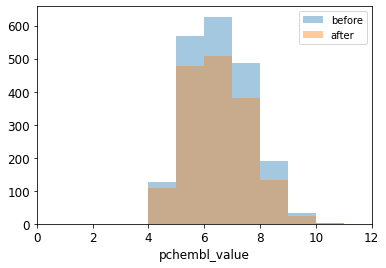

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots()


before=dset_df["pchembl_value"]

# Our after variable is comprised of our curated_df dataframe 
# Our curated_df was configured earlier to discard any out of range values
after=curated_df["pchembl_value"]

# plots the values of the response value column of both the before and after dataframes from above
# sns.distplot is a Seaborn distplot, which allows you to show a histogram with a line on it
# A distplot plots a univariate distribution of observations 
# Below, we are separating our data set into a before section and an after section 
# To break down the sns.distplot functions: 
# bins=range(0, 12, 1) is used to bin our range of values, meaning to divide the entire range of values into a series of intervals
# ax=ax 
# kde is a kernel density estimate plot that represents the data using a continuous probability density curve
# kde=False will remove the density line on the histogram
# The label= function is used to label different sections of our plot 
sns.distplot(before, bins=range(0, 12, 1), ax=ax, kde=False, label='before')
sns.distplot(after, bins=range(0, 12, 1), ax=ax, kde=False, label='after')

#configures plot by adding a legend and setting the x axis limits for readability
# plt.legend() adds the legend to the plot
plt.legend()

# ax.set_xlim is setting the x-axis limits of the graph, setting it to be from (0,12)
ax.set_xlim([0, 12])